# **Estimación de mínimos de energía en moléculas con VQE**

In [ ]:
pip install git+https://github.com/MIROptics/ECC2025.git

## Variational quantum eigensolver

Variational quantum eigensolver (VQE) [[1]](#Peruzzo2016) es un algoritmo que sirve para encontrar una cota superior para la mínima energía de un Hamiltoniano $\hat{H}$ (operador autoadjunto), es decir, el menor autovalor de $\hat{H}$. VQE es una herramienta útil en la búsqueda de una aproximación al estado basal, esto es, el autoestado asociado a la mínima energía. Para ello, VQE resuelve el problema

\begin{equation}
 \min_{|\psi\rangle}\frac{
 \langle\psi|\hat{H}|\psi\rangle}{\langle\psi|\psi\rangle}
\end{equation}

lo que significa que se busca un estado $|\psi\rangle$ que minimice el coeficiente de Rayleigh. Magnitud que puede ser eficientemente evaluada mediante un computador cuántico, y minimizada en un computador clásico. Para llevar a cabo esta tarea, se necesita aprender tres cosas:

1) Mapear el Hamiltoniano $\hat{H}$ a un computador cuántico.

2) Generar el estado $|\psi\rangle$ en un circuito cuántico paramétrico.

3) Evaluar el valor esperado del hamiltoniano $\hat{H}$.

## Primer Paso: Mapeo del Hamiltoneano

Hamiltonianos moleculares en segunda cuantización [[2]](#Tilly2022) pueden ser definidos como operadores fermiónicos mediante la función PySCFDriver() de la librería qiskit_nature.second_q.drivers.

In [ ]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(
            atom = "H 0 0 0; H 0 0 0.735",
            basis="sto3g",
            charge=0,
            spin=0,
            unit=DistanceUnit.ANGSTROM,
            )


problem = driver.run()
hamiltonian  = problem.hamiltonian
fermionic_op = hamiltonian.second_q_op()
print(fermionic_op)

Para guardar dicho Hamiltoniano se hace uso de la función json.dump() de la librería json.

In [ ]:
# Guardar operador fermiónico
import json

fermionic_op_dict = fermionic_op.__dict__

with open("fermionic_op1.json", "w") as outfile:
    json.dump(fermionic_op_dict, outfile)

Adicionalmente, mediante la función json.load() se puede cargar un Hamiltoniano previamente guardado.

In [ ]:
# Cargar operador Fermiónico
from qiskit_nature.second_q.operators.fermionic_op import FermionicOp
import json

infile = open('fermionic_op1.json')
fermionic_op_dict = json.load(infile)
fermionic_op = FermionicOp( fermionic_op_dict['_data'] )
print( fermionic_op )

Para simular sistemas fermiónicos en computadores cuánticos, los operadores fermiónicos deben ser codificados en redes de qubits. Para ello, comúnmente se utiliza la
transformación de Jordan-Wigner [[3]](#JW1928) (concretamente su transformación inversa) para convertir un Hamiltoniano fermiónico en un Hamiltoniano de spín. Esto se ejecuta en Qiskit mediante la función JordanWignerMapper() de la libreria qiskit_nature.second_q.mappers.

In [ ]:
from qiskit_nature.second_q.mappers import JordanWignerMapper
mapper = JordanWignerMapper()
qubit_op = mapper.map(fermionic_op)
print( qubit_op )

## Segundo Paso: Generar el ansatz

Nos referimos por ansatz a un circuito cuántico paramétrico que determina los estados cuánticos $|\psi({\theta})\rangle = U({\theta})|0\rangle$ considerados en la minimización de la energía. Los estados ansatz están caracterizados por secuencias de capas de compuertas paramétricas de un qubit como por ejemplo $Rx(\theta_1)R_y(\theta_2)$, las cuales se repiten un cierto número de veces, y entre cada repetición se encuentra una compuerta que entrelaza los qubits.

![Ansatz](https://raw.githubusercontent.com/MIROptics/ECC2025/refs/heads/master/talleres/05_Estimacion_minimimos_de_energia_VQE/img/Ansatz.png)

Para crear este circuito paramétrico (hardware eficiente [[2]](#Tilly2022)), debemos utilizar la función ParameterVector() de qiskit. Esta, crea un conjunto de variables simbólicas que son utilizadas como argumento en las puertas del ansatz.

**Instrucción**: Escribir una función que genere el ansatz requerido, para un número de qubits y de capas indicadas (Para el ejemplo se utiliza 4 y 2 respectivamente).



In [ ]:
# Importar librerías necesarias
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

def Hardware_Efficient_Ansatz(nqubits,reps):

  theta   = ParameterVector( '$\\theta$', 2*nqubits*(reps+1) )
  ansatz = QuantumCircuit(nqubits)

  ## completar ##

  # Compuertas iniciales



  # Layers



  return ansatz

Luego, podemos generar el ansatz del ejemplo:

In [ ]:
nqubits = fermionic_op.num_spin_orbitals
reps    = 2
ansatz = Hardware_Efficient_Ansatz(nqubits,reps)
ansatz.draw('mpl')

## Tercer Paso: Evaluar el valor de expectacion y minimizar la energía

Para estimar valores esperados de circuitos cuánticos y observables, se utiliza la función Estimator() de la librería qiskit_aer.primitives. Luego, se puede minimizar la energía mediante cualquier optimizador clásico, por ejemplo la función SPSA() de la librería qiskit.algorithms.optimizers.

**Instrucción**: Estudie la documentación de <a href="https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.Estimator#run">qiskit.algorithms.optimizers</a> de Qiskit, para ejecutar el método .run() de la función Estimator(). Esto es, completar los tres inputs faltantes en  

    estimator.run( , , , shots=100 )



In [ ]:
# Importar librerías necesarias
import numpy as np
from qiskit_aer.primitives import Estimator

estimator = Estimator()
theta = np.zeros(ansatz.num_parameters)

job = estimator.run( , , , shots=100 )

values = job.result().values
print(values)

[-0.0081419]


**Intrucción**: Revise la documentación de <a href="https://docs.quantum.ibm.com/api/qiskit/0.40/qiskit.algorithms.optimizers.Optimizer">Optimizer</a> de Qiskit, para realizar la minimización de la función objetivo. Esto es, completar los inputs de
    optimizer.minimize( , )

In [ ]:
from qiskit_algorithms.optimizers import SPSA

data_per_iter = []
callback      = lambda evals_num, params, fun_value, stepsize, step_accepted : data_per_iter.append( fun_value )

maxiter   = 200
optimizer = SPSA( maxiter=maxiter, callback=callback )

obj_func = lambda theta : estimator.run( ansatz,
                                        qubit_op,
                                        theta,
                                        shots=100 ).result().values

initial_params = np.random.randn(ansatz.num_parameters)

results = optimizer.minimize( , )
print(results)

**Observación**: Observe el output de optimizer.minimize( , ) y vea como obtener el valor mínimo y los parámetros que determinan el estado de mínima energía. Además, note que en la variable *data_per_iter* se guardó los valores de la minimización en cada iteración.

## Analisis de resultados

Para determinar la performance (convergencia y velocidad de convergencia) del optimizador en la minimización de la energía, se necesita un valor mínimo de referencia. Para este ejemplo pedagógico, podemos hacer "trampa" y calcular dicho mínimo clásicamente al diagonalizar el Hamiltoniano $\hat{H}$.


In [ ]:
from qiskit_algorithms.eigensolvers import NumPyEigensolver

classical_solver  = NumPyEigensolver()
results_classical = classical_solver.compute_eigenvalues( qubit_op )
min_of_energy     = results_classical.eigenvalues
print(min_of_energy)

[-1.85727503]


Luego podemos graficar los valores obtenidos mediante la minimización.

In [ ]:
import matplotlib.pyplot as plt

plt.plot( data_per_iter )
plt.plot( [maxiter], [results.fun], 'o' )
plt.hlines( min_of_energy, 0, maxiter, color='tab:red' )
plt.xlabel('Número de iteraciones')
plt.ylabel('Energía')

## Implementación de VQE

Para realizar una implementación de VQE solo resta juntar los tres pasos anteriores.

**Instruccion**: Escribir una función que entregue una estimación del mínimo de la energía y los parámetros $\theta$ que determinan el estado que la minimiza. Para ello debe entregarse al programa el número de layers que considera el ansatz y el número de iteraciones del optimizador clásico (SPSA en este caso).

In [ ]:
## Importamos todas las librerias
#pip install git+https://github.com/LucianoPereiraValenzuela/ECC_2025_testing.git

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.optimizers import QNSPSA
from qiskit.primitives import Sampler

def VQE(qubit_op, reps, maxiter):

    # Definir el Ansatz


    # realizar la optimización

    return results.fun, results.x, data_per_iter


**Instrucción:** Cargue el Hamiltoniano generado previamente y llame a la función VQE. Finalmente, realice un gráfico que muestre la estimación de la energía mínima entregada por VQE en cada iteración.

In [ ]:
# Cargar librerias en caso de no haberlo hecho antes
from qiskit_nature.second_q.operators.fermionic_op import FermionicOp
import json
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms.eigensolvers import NumPyEigensolver

## Paso 1: Definir Hamiltoniano
# Cragar Hamiltoneano

fermionic_op =

# Mapear Hamiltoniano

qubit_op =


## Implementacion (LLamar a función VQE)
reps =
maxiter =

estimated_energy, estimated_theta, data_per_iter =

##  Analisis de resultados

# Obtener valor de referencia (Esto no se puede hacer siempre. Aqui se puede por que es un ejemplo simple)

min_of_energy =

# Plotear resultados

## Tarea 1:

Comparar el funcionamiento de la función VQE al considerar distintos números de layers.

<ipython-input-15-9e4633ef746e>:7: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  estimated_energy, estimated_theta, data_per_iter = VQE(qubit_op, capas[k], maxiter)
<ipython-input-15-9e4633ef746e>:7: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  estimated_energy, estimated_theta, data_per_iter = VQE(qubit_op, capas[k], maxiter)
<ipython-input-11-44cc85b3f467>:27: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  fidelity = QNSPSA.get_fidelity(ansatz, sampler = Sampler())
<ipython-in

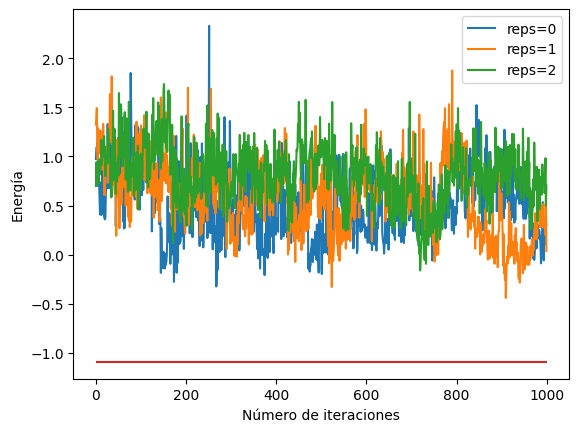

In [ ]:
results_per_rep = []
capas = []
maxiter =

for k in range(len(capas)):
    estimated_energy, estimated_theta, data_per_iter = VQE(qubit_op, capas[k], maxiter)
    plt.plot( data_per_iter, label='reps={}'.format(k) )

plt.hlines( min_of_energy, 0, maxiter, color='tab:red' )
plt.xlabel('Número de iteraciones')
plt.ylabel('Energía')
plt.legend()

## Tarea 2:

Cambiar el optimizador clásico utilizado en la función VQE (SPSA). Para ello revise la documentación de Qiskit respecto a <a href="https://docs.quantum.ibm.com/api/qiskit/qiskit.algorithms.optimizers">optimizadores</a>. Por ejemplo, para utilizar el optimizador QN-SPSA se debe cargar las funciones

    from qiskit.algorithms.optimizers import QNSPSA
    from qiskit.primitives import Sampler

 y remplazar el optimizador utilizado, mediante el siguiente segmento de código:
      
    fidelity = QNSPSA.get_fidelity( ansatz, Sampler() )
    optimizer = QNSPSA( fidelity=fidelity, maxiter=maxiter, callback=callback )

Observacion: Para este ejemplo, el optimizador QN-SPSA funciona peor que SPSA, requiriendo cerca de 1000 iteraciones para converger.   

## Tarea 3:

Ejecutar la implementación de VQE para simular la partícula de LiH. Para ello, utilice el operador fermiónico guardado en la variable <a href="https://drive.google.com/file/d/1yaw3kj-e4Du4cZh2b3DNRsQhyjnZ2WF2/view?usp=drive_link">fermionic_op2.json</a>. Además, determine el número de layers adecuado a considerar en el ansatz y el optimizador más favorable para alcanzar una buena estimación del mínimo de la energía.


## Referencias

<a id='Peruzzo2016'>[1]</a> Peruzzo, A., McClean, J., Shadbolt, P. et al. A variational eigenvalue solver on a photonic quantum processor. *Nat Commun 5*, 4213 (2014). https://doi.org/10.1038/ncomms5213

<a id='Tilly2022'>[2]</a> Jules Tilly, Hongxiang Chen, Shuxiang Cao, Dario Picozzi, Kanav Setia, Ying Li, Edward Grant, Leonard Wossnig, Ivan Rungger, George H. Booth, Jonathan Tennyson,
The Variational Quantum Eigensolver: A review of methods and best practices,
*Physics Reports*,
Volume 986,
2022,
Pages 1-128,
ISSN 0370-1573,
https://doi.org/10.1016/j.physrep.2022.08.003.

<a id='JW1928'>[3]</a> Jordan, P., Wigner, E. Über das Paulische Äquivalenzverbot. Z. *Physik* 47, 631–651 (1928). https://doi.org/10.1007/BF01331938

## Contactos:

Mario Muñoz <br>
Doctor en Ciencias Aplicadas Mención en Ingeniería Matemática, Universidad de Concepción <br>
Postdoc, Fundación Getulio Vargas, Rio de Janeiro, Brazil <br>
munozmunozmarioalejandro@gmail.com

Luciano Pereira <br>
Doctor en Ciencias Física, IFF-CSIC, Spain <br>
luciano.pereira.valenzuela@gmail.com